# Scenario Building

In [141]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import time
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from kneed import KneeLocator

#make plot default more academic (bold axis, etc)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.title_fontsize"] = 12


In [177]:
#import the necessary data
# Load the simulated load data
sim_data = pd.read_csv('SNI_Load.csv')
# Load the solar and wind data
solar_data = pd.read_csv('solarfinal.csv')
wind_data = pd.read_csv('Windfinal2.csv')
kwperturbine = 100 #kW
#make nuclear data with the same first column and a second column ('kWh') of matching length with repeated 2000s
nuclear_data = pd.DataFrame(sim_data['Date'])
nuclear_data['kWh'] = 1000.0 #set the eletrical capacity of the nuclear plant 

sim_data.set_index('Date', inplace=True)
solar_data.set_index('Date', inplace = True)
wind_data.set_index('Date', inplace = True)
nuclear_data.set_index('Date', inplace = True)
#convert all indices to datetime
sim_data.index = pd.to_datetime(sim_data.index)
solar_data.index = pd.to_datetime(sim_data.index)
wind_data.index = pd.to_datetime(sim_data.index)
nuclear_data.index = pd.to_datetime(sim_data.index)

demand = sim_data['kWh']
batteff = .90

#print max demand
print(demand.max())
print(demand.min())
print(demand.sum())

753.0
362.0
4548154.0


In [143]:
#Diesel function
def calculate_diesel(unmet_demand):
    diesel = []
    fuel = []
    i  = unmet_demand
    opcap = 500
    coeffs = [-1.03886878e-06,  2.70529957e-04, -2.68484638e-02,  1.36302395e+00, 1.29690135e+00] # fit to diesel efficiency curve

    def galcalc(opcap, op):
        outp = op/opcap*100
        eff = p(outp)/100  # Assuming p is a function defined elsewhere in your code
        kwh = op/eff
        gal = kwh/37.5
        return gal

    p = np.poly1d(coeffs)
    if i > -.001:
        diesel = (0)
        fuel = (0)
    else:
        if i > -250:
            diesel = 250
            opcap = 825
            fuel = galcalc(opcap, 250)
        elif i > -825:
            diesel = (-i)
            opcap = 825
            fuel = (galcalc(opcap, -i))
        elif i > -1000:
            opcap = 1000
            diesel = (-i)
            fuel = (galcalc(opcap, -i))
        elif i > -2000:
            opcap = 2000
            diesel = (-i)
            fuel = (galcalc(opcap, -i))
        else:
            opcap = 20000
            diesel = (-i)
            fuel = (galcalc(opcap, -i))

    return diesel, fuel

In [144]:
#Energy Simulation Function
def simulate_energy(scenario):
    turbinenumber = scenario[0]
    solarcount = scenario[1]
    nucleargens = scenario[2]
    battpower = scenario[3]
    battcap = scenario[4]*.6 #Depth of discharge relegated from 80% to 20% to increase battery life
    dieselstatus = scenario[5]
    # Use the function arguments to calculate wind, solar, and nuclear
    wind = turbinenumber*wind_data['kWh']
    solar = solarcount*solar_data['kWh']
    nuclear = nucleargens*nuclear_data['kWh']
  
    supplytotal = wind + solar + nuclear
    #power system calculation
    #Battery
    battery = []
    charge = battcap
    discharge = []
    curtailed = []
    diesel = []
    fuel = []
    curtail = 0
    for i in supplytotal - demand:
            icharge = charge
            if i > 0.0000001:
                if i > battpower:
                    charge = charge + battpower*batteff
                    curtail = i-battpower
                else:
                    charge = charge + i*batteff
                    curtail = 0 
                if charge > battcap:
                    curtail = curtail + icharge+(charge-icharge)/batteff - battcap
                    charge = battcap
                battery.append(charge)
                discharge.append(0)
                curtailed.append(curtail)
                diesel.append(0)
                fuel.append(0)
            else:
                if dieselstatus == 0:
                    if i < -battpower:
                        charge = charge - battpower
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(battpower*batteff)
                    else:
                        charge = charge + i/batteff
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(-i)
                    battery.append(charge)
                    curtailed.append(0)
                    diesel.append(0)
                    fuel.append(0)
                else:
                    if i < -battpower:
                        charge = charge - battpower
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(battpower*batteff)
                    else:
                        charge = charge + i/batteff
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(-i)
                    battery.append(charge)
                    if i+discharge[-1] >= 0-.0000001:
                        diesel.append(0)
                        fuel.append(0)
                    else:   
                        dieseln, fueln = calculate_diesel(i+discharge[-1])
                        fuel.append(fueln)
                        diesel.append(dieseln)
                        if dieseln + i +discharge[-1] > 0-.0000001 and discharge[-1] > 0:
                            discharge[-1] = discharge[-1]-(discharge[-1]+dieseln + i)
                            battery[-1] = battery[-1] + discharge[-1] + dieseln + i
                    curtailed.append(0)
                if diesel[-1] + i + discharge[-1]> 0-.00000001 and diesel[-1] != 0:
                    curtailed[-1] = diesel[-1] + i+ discharge[-1]

        # Calculate the total supply
    supplytotal = wind + solar + nuclear + discharge + diesel

    

    fuel_data = pd.DataFrame(sim_data.index)
    fuel_data['gal'] = fuel
    fuel_data.set_index('Date', inplace = True)
    fuel_data = fuel_data.round(2)
    #make fuel data cumulative
    fuel_data['cumulative'] = fuel_data['gal'].cumsum()

    fuel = np.array(fuel_data['cumulative'])

    battery = np.array(battery)
    battery_data = pd.DataFrame(sim_data.index)
    battery_data['kWh'] = battery
    battery_data.set_index('Date', inplace = True)
    
    #create the discharge DataFrame
    discharge = np.array(discharge)
    discharge_data = pd.DataFrame(sim_data.index)
    discharge_data['kWh'] = discharge
    discharge_data.set_index('Date', inplace = True)

    #create the curtailed DataFrame
    curtailed = np.array(curtailed)
    curtailed_data = pd.DataFrame(sim_data.index)
    curtailed_data['kWh'] = curtailed
    curtailed_data.set_index('Date', inplace = True)
    #make curtailed data cumulative
    curtailed_data['cumulative'] = curtailed_data['kWh'].cumsum()
    curtailedcum = np.array(curtailed_data['cumulative'])
    
    count = 0
    for s, d in zip(supplytotal, demand):
        if s >= d-.0000001:
            count += 1
    
    #return the total amount of fuel used
    # Create a DataFrame with data for each generation type, fuel usage, and curtailed electricity
    data = pd.DataFrame({
        'Wind': wind,
        'Solar': solar,
        'Nuclear': nuclear,
        'Battery': discharge,
        'Diesel': diesel,
        'Fuelcum': fuel,  
        'Curtailed': curtailed,
        'Curtailedcum': curtailedcum,
        'Metdemand' : count
    }, index=sim_data.index)
    
    return data
    # Return number of hours with satisfied demand


In [145]:
#Carbon Measurement Function
def calculate_carbon(scenario):
    # Calculate the carbon emissions for each generation type
    turbinenumber = scenario[0]
    solarcount = scenario[1]
    nucleargens = scenario[2]
    battcap = scenario[4]
    dieselstatus = scenario[5]
    data = simulate_energy(scenario)
    fuel = data['Fuelcum']
    curtailed = data['Curtailedcum']
    #stage emissions data
    kwperturbine = 100 #kW
    dieselpower = 500 #kW
    solarembodied = 0.278267*1000*.66666666 #kgCO2/kWp modified for 20 years
    windembodied =  2615 * kwperturbine ** .7462 #kgCO2/turbine
    batteryembodied = 110  #kg/kWh modified for 20 years

    # #B stage emissions
    jp5emissions = 9.8 #kgCO2/gal

    
    # #Calculate total emissions for the A stage (pre)
    # A = (solarcount*solarA + turbinenumber*windA*kwperturbine + nucleargens*nuclearA + battA*battcap)/1000 #kgCO2
    # #Calulcate emissions in the B stage (use-during)
    fuelshipment = 100000 #gallons
    galpertonne = 328.36 #gallons
    shipcarbon = 10.6 #CO2e g/tkm
    carbonpershipment = fuelshipment/galpertonne*shipcarbon/1000 #kgCO2
    dist = 150 # km
    carbonpershipment = fuelshipment/galpertonne*shipcarbon*dist/1000 #kgCO2
    B = (fuel.iloc[-1]*jp5emissions)+fuel.iloc[-1]/fuelshipment*carbonpershipment#kgCO2 #high PM2.5 emissions #fuel transport
    B = B*20 #20 years of data 
    # #Calculate emissions in the C stage (End of Life)
    # C = (solarcount*solarC + turbinenumber*windC*kwperturbine + nucleargens*nuclearC + battC*battcap)/1000 #kgCO2

    # #Calculate total emissions
    embodied = solarcount*solarembodied + turbinenumber*windembodied + battcap*batteryembodied  
    total = B + embodied
    #convert to tCO2
    total = total/1000
    B = B/1000
    embodied = embodied/1000
    return total, B, embodied, fuel.iloc[-1], curtailed.iloc[-1]

In [146]:
def calculate_cost(scenario):
    # Calculate the carbon emissions for each generation type
    turbinenumber = scenario[0]
    solarcount = scenario[1]
    nucleargens = scenario[2]
    battcap = scenario[4]
    dieselstatus = scenario[5]
    data = simulate_energy(scenario)
    fuel = data['Fuelcum']
    curtailed = data['Curtailedcum']
    #stage emissions data
    kwperturbine = 100 #kW
    dieselpower = 500 #kW
    solarembodied = 876#cost per k2
    windembodied =  1274 #cost per kw
    batteryembodied = 500 #dollars per kWh

    B = (fuel.iloc[-1]*4.92)*20#cost of fuel for 20 years
    # #Calculate emissions in the C stage (End of Life)
    # C = (solarcount*solarC + turbinenumber*windC*kwperturbine + nucleargens*nuclearC + battC*battcap)/1000 #kgCO2

    # #Calculate total emissions
    embodied = solarcount*solarembodied + turbinenumber*windembodied*kwperturbine + battcap*batteryembodied  
    total = B + embodied
    #divide each by 1000000

    return total,B,embodied

In [147]:
def find_stable_x(x, y, threshold=0.0005):
    for i in range(1, len(y)):
        change = abs(y[i] - y[i-1]) / y[i-1]
        if change < threshold:
            return x[i]
    return None

In [148]:
# Plot Gen: Time Period
def plot_generation(data, start, end):
    # Create a new DataFrame with only the data between the start and end dates
    data_subset = data[start:end].copy()
    data_subset['Day'] = range(len(data_subset))  # Add a 'Day' column
    data_subset['Day'] = data_subset['Day']/24

    plt.figure(figsize=(12, 6))
    colors = ['red', 'blue', 'yellow', 'green']  # Specify your own colors here
    stack_plots = plt.stackplot(data_subset['Day'], data_subset['Diesel'], data_subset['Battery'], data_subset['Solar'], data_subset['Wind'], colors=colors)

    # Add a dotted line that traces demand for the two summer days
    demand_line = plt.plot(data_subset['Day'], demand[start:end], 'k--', label = 'Demand')  # Assuming demand is defined somewhere in your code

    # Calculate total energy for the two summer days
    total_energy = data_subset['Diesel'] + data_subset['Battery'] + data_subset['Solar'] + data_subset['Wind']

    # Shade the area between the stacked plot and the curtailed line
    curtailed_fill = plt.fill_between(data_subset['Day'], total_energy, total_energy - data_subset['Curtailed'], color='red', alpha=0.5, hatch='///')
    curtailed_patch = mpatches.Patch(color='red', alpha=0.5, hatch='///', label='Curtailed Energy')

    plt.xlabel('Days')
    plt.ylabel('kWh Generated')
    plt.title('Simulated Generation')

    # Create the first legend and add it to the plot
    first_legend = plt.legend(stack_plots[::-1], ['Diesel', 'Battery', 'Solar', 'Wind'][::-1], loc='upper left')
    plt.gca().add_artist(first_legend)

    # Create the second legend and add it to the plot
    plt.legend([demand_line[0], curtailed_patch], ['Demand', 'Curtailed Energy'], loc='upper right')    

    plt.show()

# Scenarios

### Base

(74512.43595622481, 74512.43595622481, 0.0, 379977.7399999935, 0.0)
(37389809.615999356, 37389809.615999356, 0)


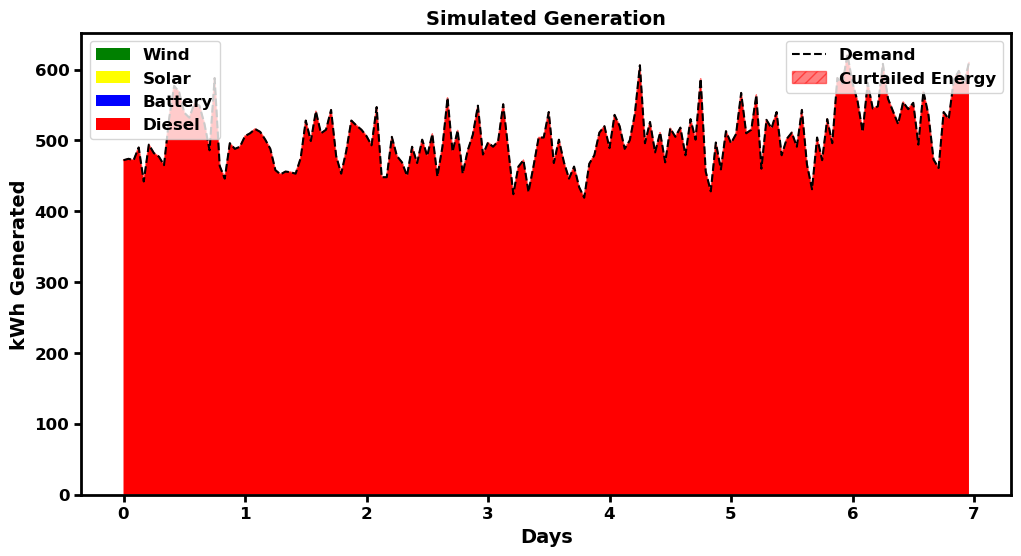

In [149]:
base = [0,0,0,0,0,1]
print(calculate_carbon(base))
print(calculate_cost(base))
plot_generation(simulate_energy(base), '2019-05-01', '2019-05-07')

### Solar

2000
5400
8900


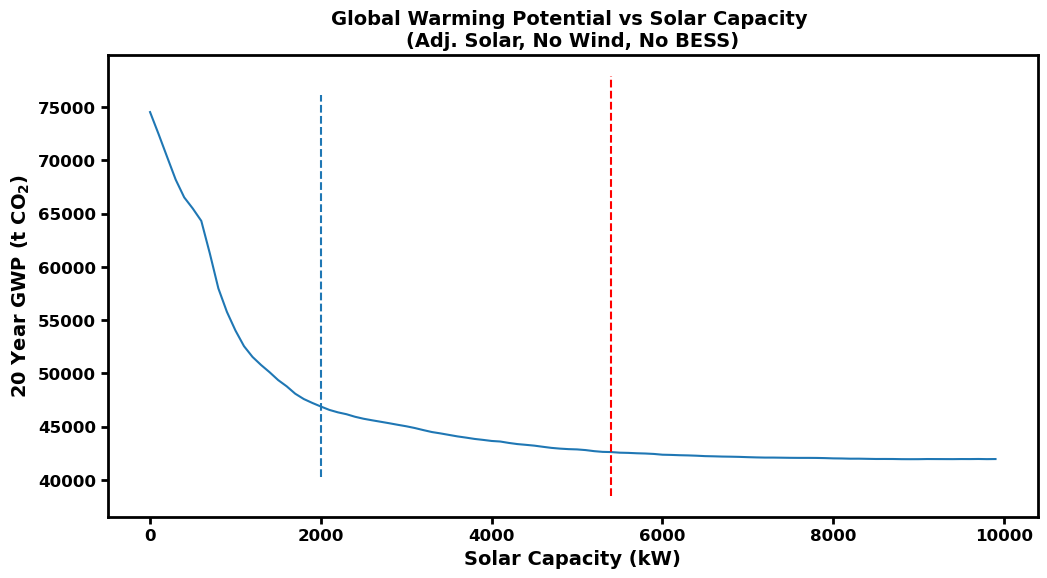

In [150]:
# Solar Sizing No battery
solsize = np.arange(0, 10000, 100)
fdem = []
for i in solsize:
    scenario = [0, i, 0, 0, 0, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(solsize, fdem)
plt.xlabel('Solar Capacity (kW)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Solar Capacity \n(Adj. Solar, No Wind, No BESS)')
#set bottom y to 0
#plt.ylim(0, 130000000)
#print the solar for lowest emissions
knee_locator = KneeLocator(solsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
plt.vlines(find_stable_x(solsize, fdem), plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red')
print(find_stable_x(solsize, fdem))
print(solsize[np.argmin(fdem)])


(46901.340893686436, 46530.318230729994, 371.02266295644, 237282.34000000157, 1882130.0)
(25100582.256000154, 23348582.256000154, 1752000)


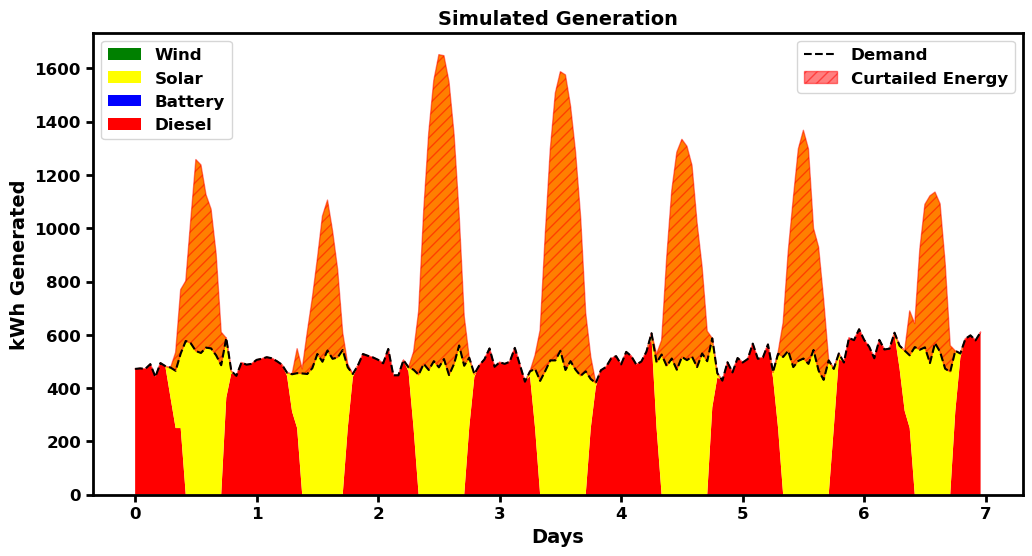

In [151]:
solar1 = [0, 2000, 0,0, 0,1]
print(calculate_carbon(solar1))
print(calculate_cost(solar1))
plot_generation(simulate_energy(solar1), '2019-5-1', '2019-5-7')

(42629.097460578145, 41627.33627059576, 1001.761189982388, 212279.48000000036, 7844303.799999989)
(42629.097460578145, 41627.33627059576, 1001.761189982388, 212279.48000000036, 7844303.799999989)


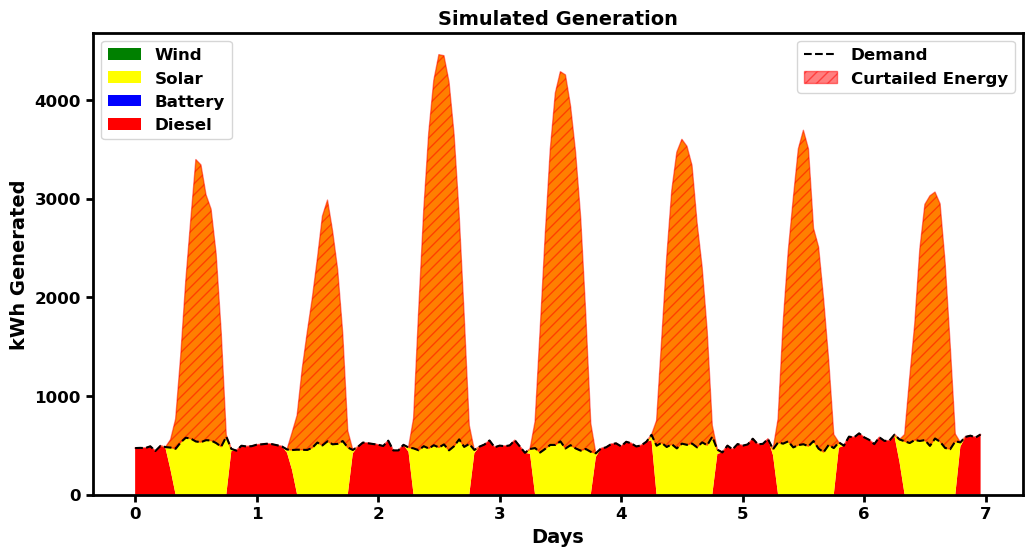

In [152]:
solar2 = [0, 5400, 0,0, 0,1]
print(calculate_carbon(solar2))
print(calculate_carbon(solar2))
plot_generation(simulate_energy(solar2), '2019-5-1', '2019-5-7')

### Solar + BESS

8800
10800


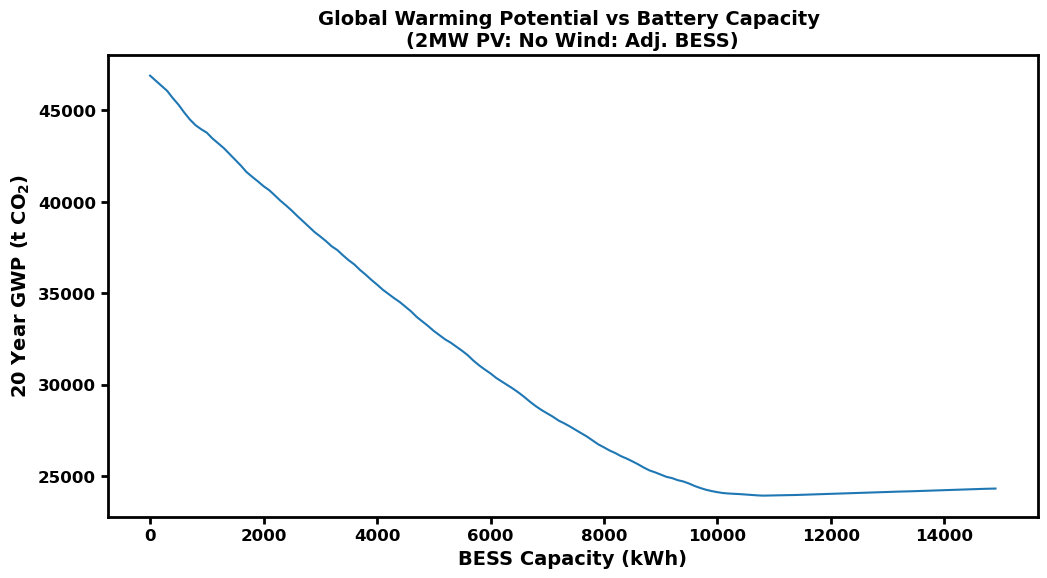

In [153]:
#solar 2000
batsize = np.arange(0, 15000, 100)
fdem = []
for i in batsize:
    scenario = [0, 2000, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('BESS Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Capacity \n(2MW PV: No Wind: Adj. BESS)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
#plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#plt.vlines(find_stable_x(solsize, fdem), plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red')
#print(find_stable_x(solsize, fdem))
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

(24128.444319431266, 22657.421656474828, 1471.02266295644, 115542.00000000116, 89416.69999999998)


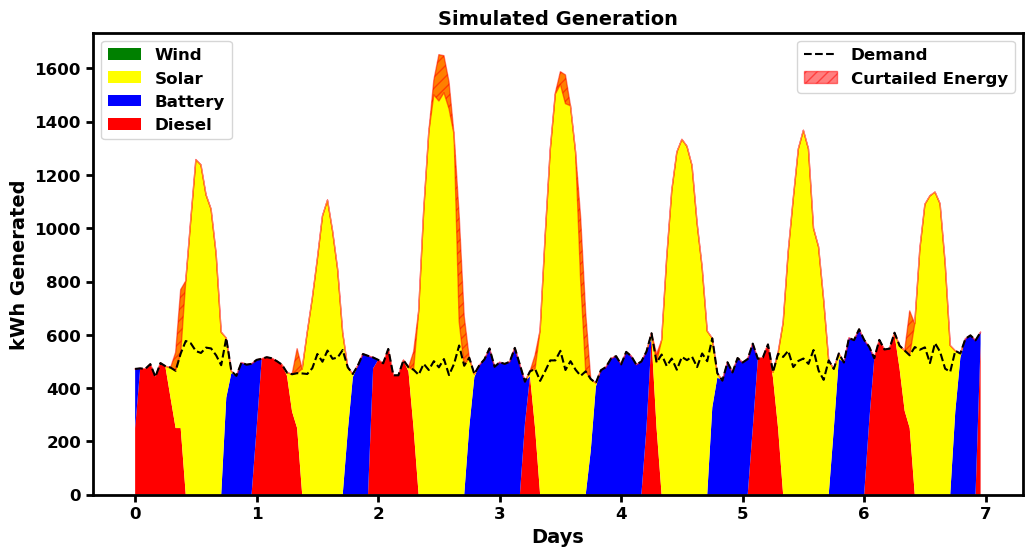

In [154]:
solarBESS1 = [0, 2000, 0, 1000, 10000, 1]
print(calculate_carbon(solarBESS1))
plot_generation(simulate_energy(solarBESS1), '2019-5-1', '2019-5-7')

11400
14800


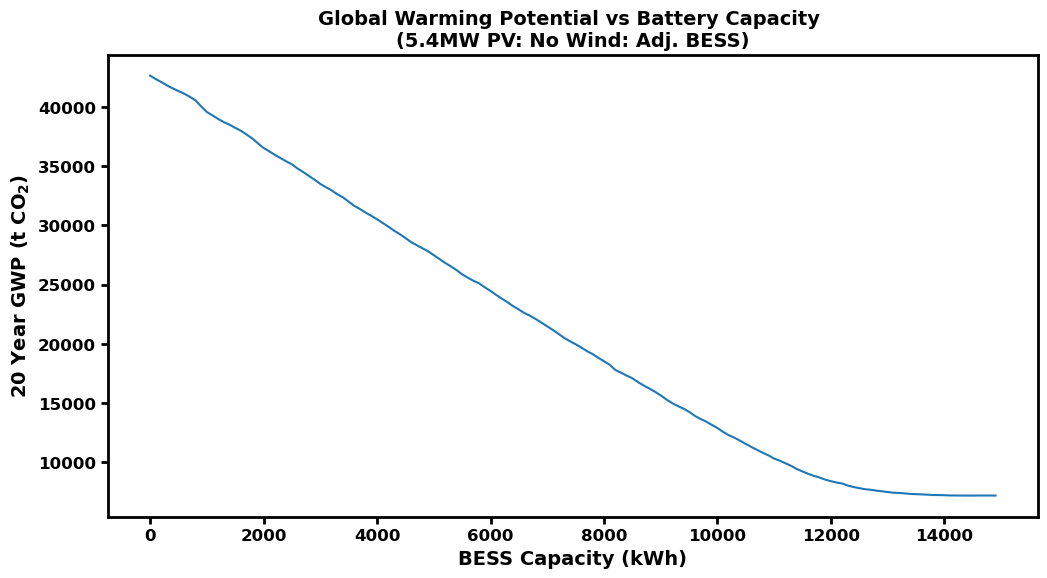

In [155]:
#solar 5400
batsize = np.arange(0, 15000, 100)
fdem = []
for i in batsize:
    scenario = [0, 5400, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('BESS Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Capacity \n(5.4MW PV: No Wind: Adj. BESS)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
#plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#plt.vlines(find_stable_x(solsize, fdem), plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red')
#print(find_stable_x(solsize, fdem))
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

(8417.17080571268, 6095.409615730291, 2321.7611899823883, 31083.669999999973, 5188240.893333328)


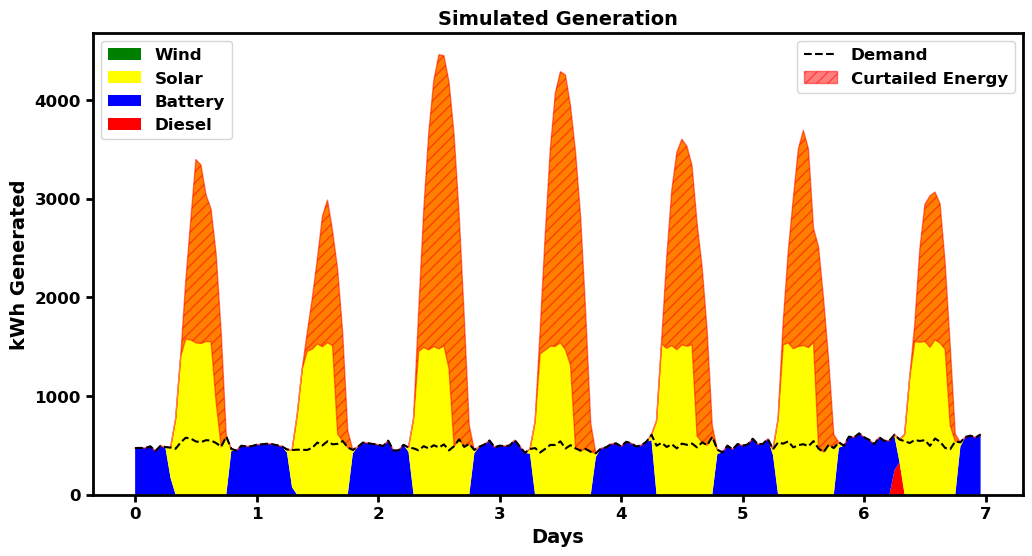

In [156]:
solarBESS2 = [0, 5400, 0, 1000, 12000, 1]
print(calculate_carbon(solarBESS2))
plot_generation(simulate_energy(solarBESS2), '2019-5-1', '2019-5-7')

### Wild

3000
85


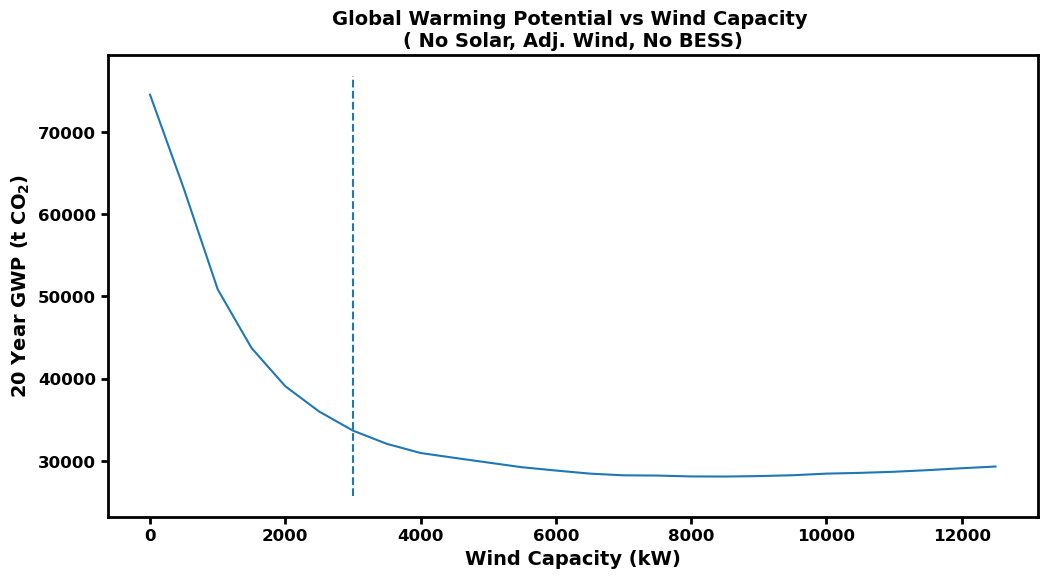

In [157]:
# same for wind
windsize = np.arange(0, 130, 5)
fdem = []
for i in windsize:
    scenario = [i, 0, 0, 0, 0, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(windsize*kwperturbine, fdem)
plt.xlabel('Wind Capacity (kW)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Wind Capacity \n( No Solar, Adj. Wind, No BESS)')
knee_locator = KneeLocator(windsize*kwperturbine, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the wind for lowest emissions
print(windsize[np.argmin(fdem)])

(39064.09046505423, 37438.909642720995, 1625.1808223332305, 190920.51000000414, 2131717.419052108)


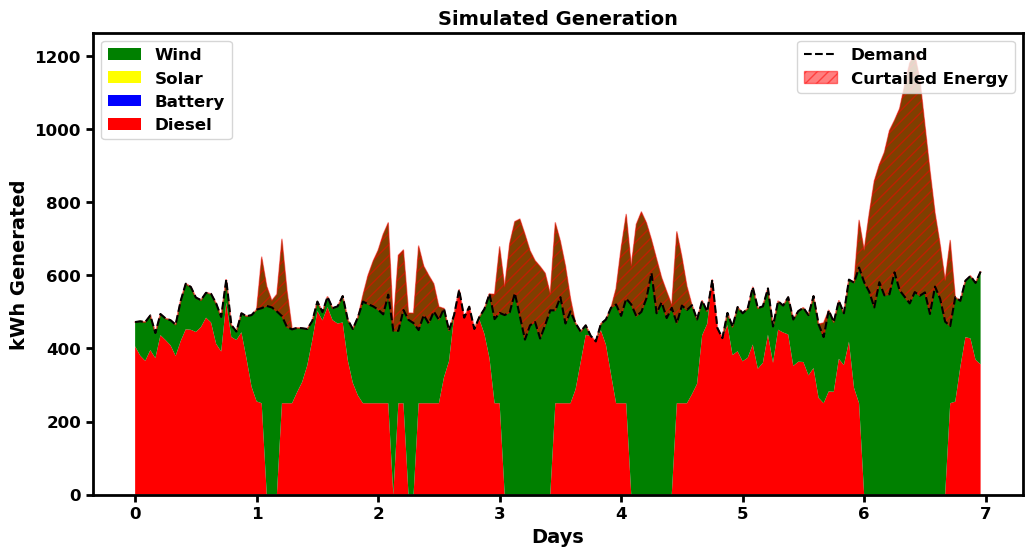

In [158]:
wind1 = [20, 0, 0,0, 0,1]
print(calculate_carbon(wind1))
plot_generation(simulate_energy(wind1), '2019-5-1', '2019-5-7')

(28237.671855404995, 22549.538977238688, 5688.132878166307, 114991.85000000148, 12764250.127606453)
(20233198.040000144, 11315198.040000144, 8918000)


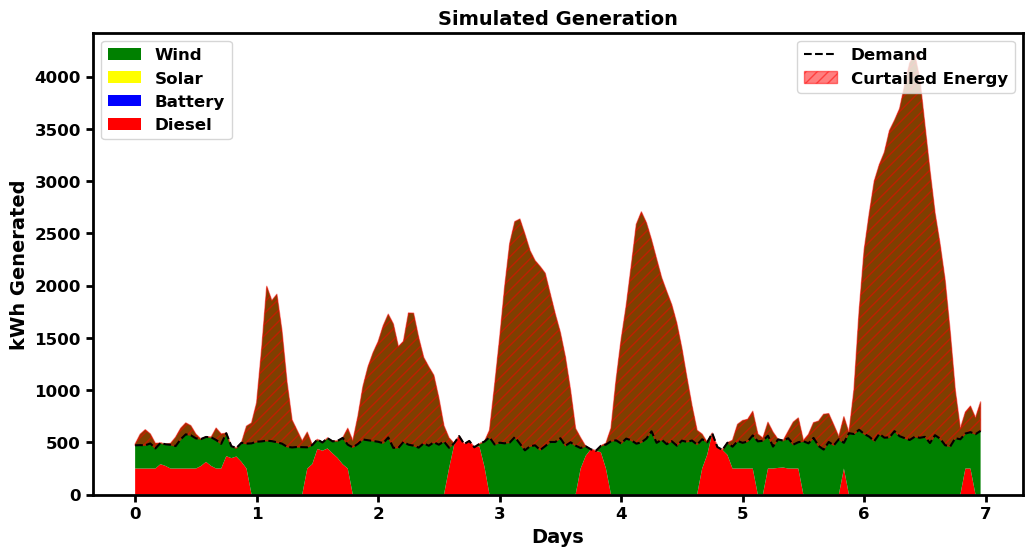

In [159]:
wind2 = [70, 0, 0,0, 0,1]
print(calculate_carbon(wind2))
print(calculate_cost(wind2))
plot_generation(simulate_energy(wind2), '2019-5-1', '2019-5-7')

### Wind + BESS

9000
39000


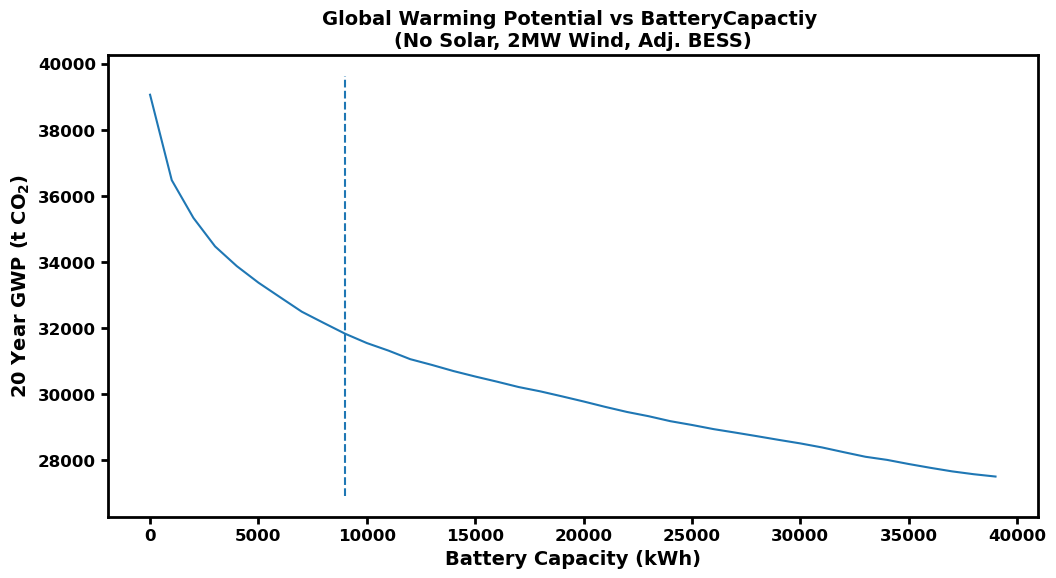

In [160]:
batsize = np.arange(0, 40000, 1000)
fdem = []
for i in batsize:
    scenario = [20, 0, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs BatteryCapactiy \n(No Solar, 2MW Wind, Adj. BESS)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

(31552.013160908424, 28826.83233857519, 2725.1808223332305, 147003.0400000023, 1579134.0418458772)


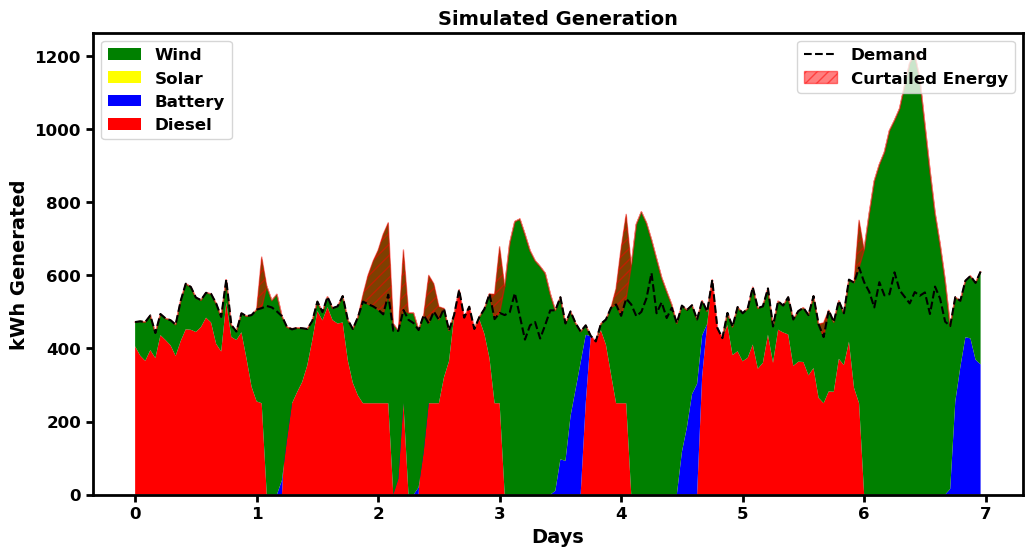

In [161]:
windBESS1 = [20, 0, 0,1000, 10000,1]
print(calculate_carbon(windBESS1))
plot_generation(simulate_energy(windBESS1), '2019-5-1', '2019-5-7')

12000
39000


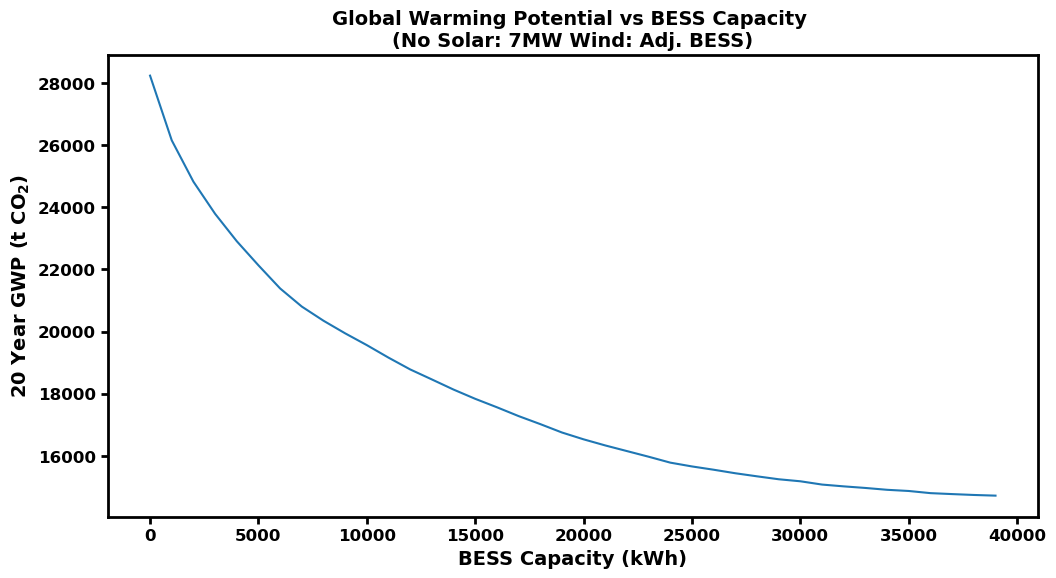

In [162]:
batsize = np.arange(0, 40000, 1000)
fdem = []
for i in batsize:
    scenario = [70, 0, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('BESS Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs BESS Capacity \n(No Solar: 7MW Wind: Adj. BESS)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
#plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

(18781.601155538694, 11773.468277372385, 7008.132878166307, 60039.04999999994, 12022703.931655819)


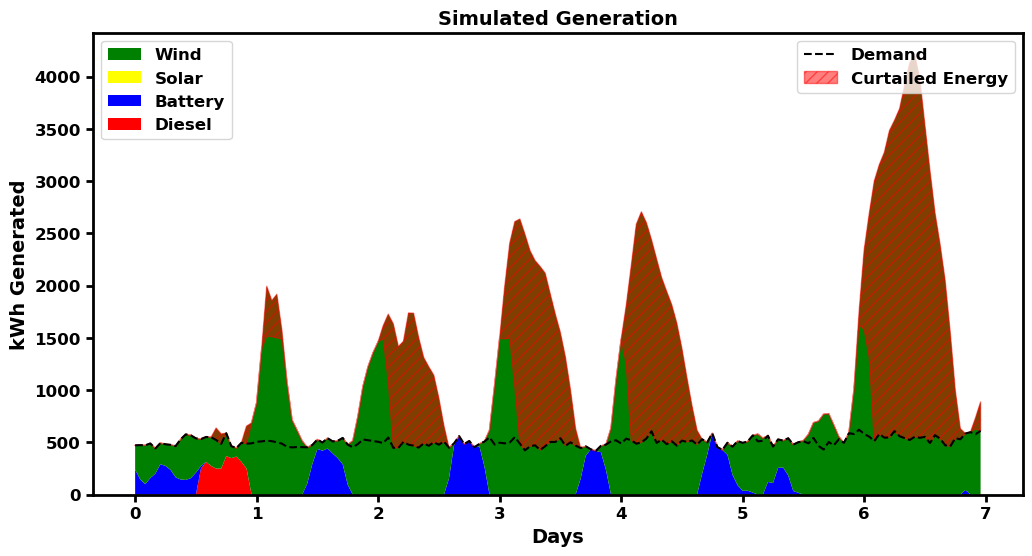

In [163]:
windBESS2 = [70, 0, 0,1000, 12000,1]
print(calculate_carbon(windBESS2))
plot_generation(simulate_energy(windBESS2), '2019-5-1', '2019-5-7')

### hybrid

(7542.946526018139, 4446.743040728468, 3096.2034852896704, 22676.26, 3735394.1170882313)


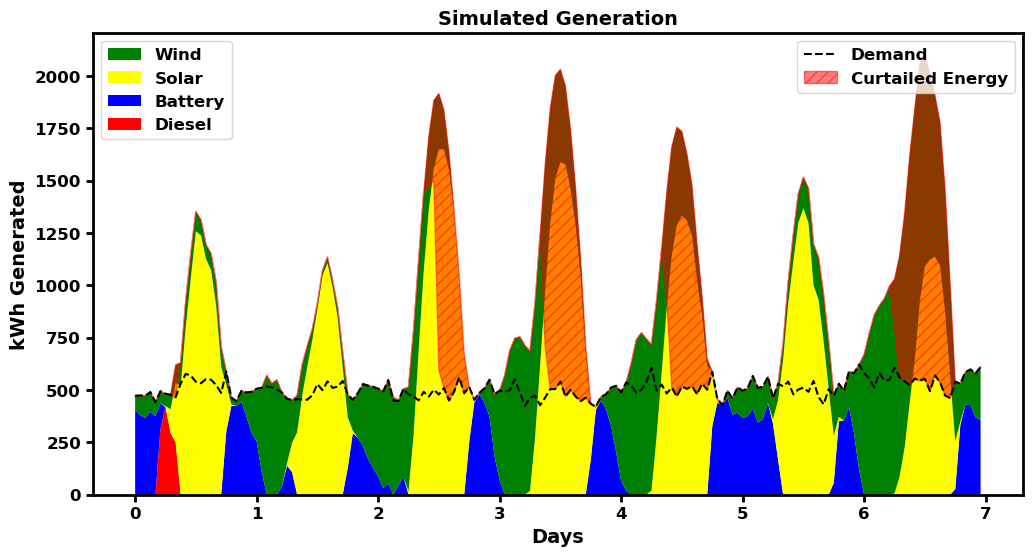

In [164]:
hybrid1 = [20, 2000, 0, 1000, 10000, 1]
print(calculate_carbon(hybrid1))
plot_generation(simulate_energy(hybrid1), '2019-5-1', '2019-5-7')

(8350.549585217766, 340.6555170690705, 8009.894068148695, 1737.1799999999998, 21241014.88221242)


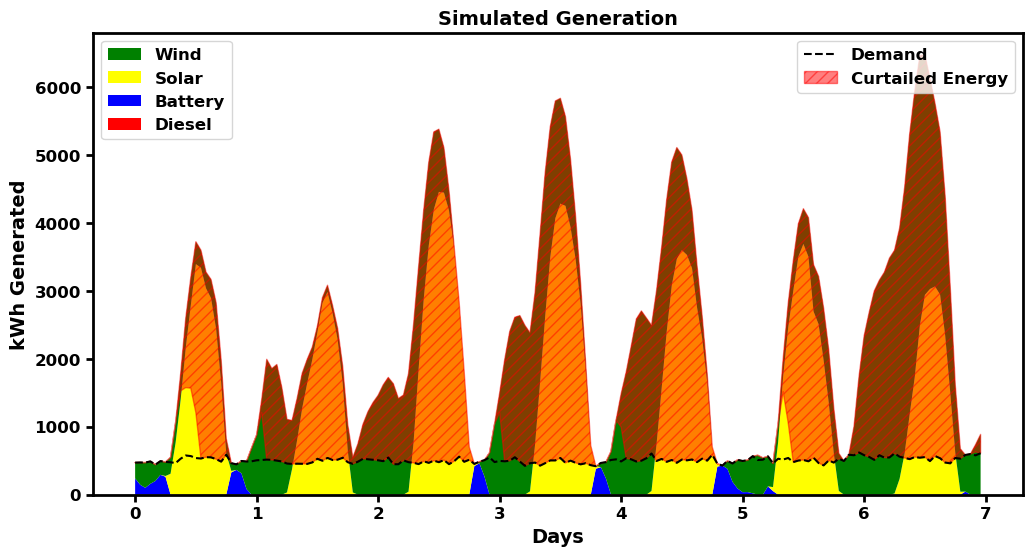

In [165]:
hybrid2 = [70, 5400, 0, 1000, 12000, 1]
print(calculate_carbon(hybrid2))
plot_generation(simulate_energy(hybrid2), '2019-5-1', '2019-5-7')

### Renewable Grid


(6014.214533776227, 0.0, 6014.214533776227, 0, 21423892.110477924)


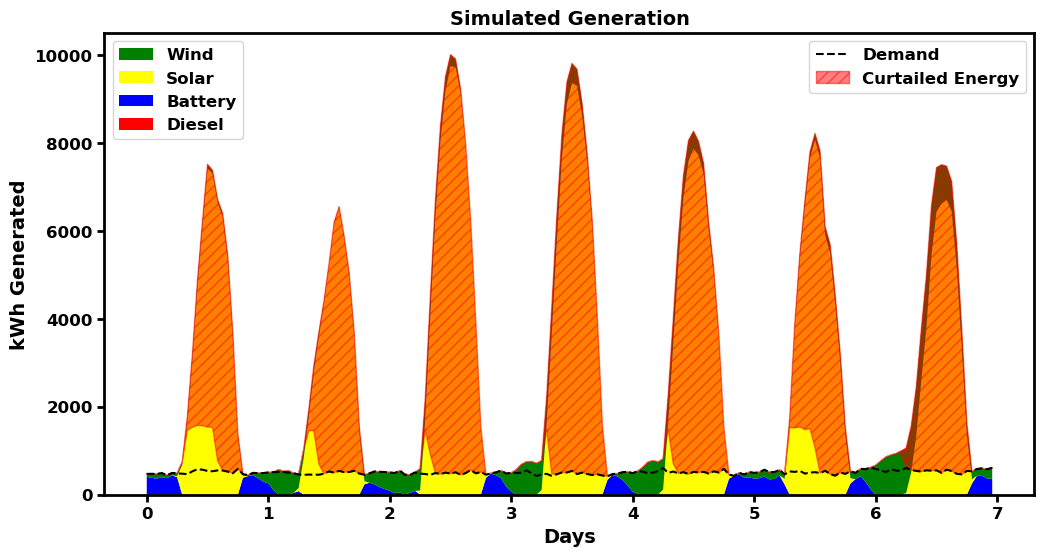

In [166]:
renewableonly1 = [20, 11800, 0,1000,20000,1]
print(calculate_carbon(renewableonly1))
plot_generation(simulate_energy(renewableonly1), '2019-5-1', '2019-5-7')

(8933.530328878998, 0.0, 8933.530328878998, 0, 27082355.28199787)


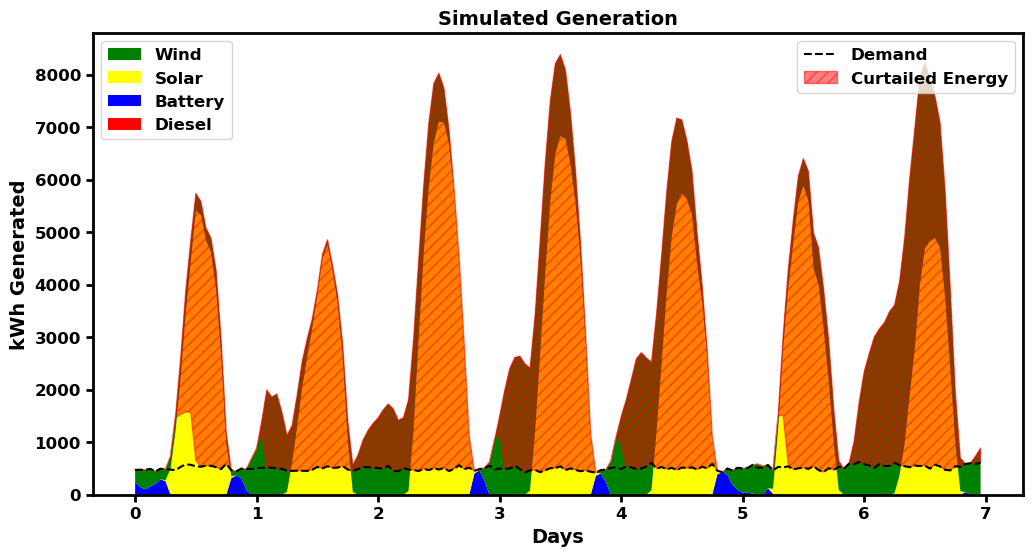

In [171]:
renewableonly2 = [70, 8600, 0,1000,15000,1]
print(calculate_carbon(renewableonly2))
plot_generation(simulate_energy(renewableonly2), '2019-5-1', '2019-5-7')

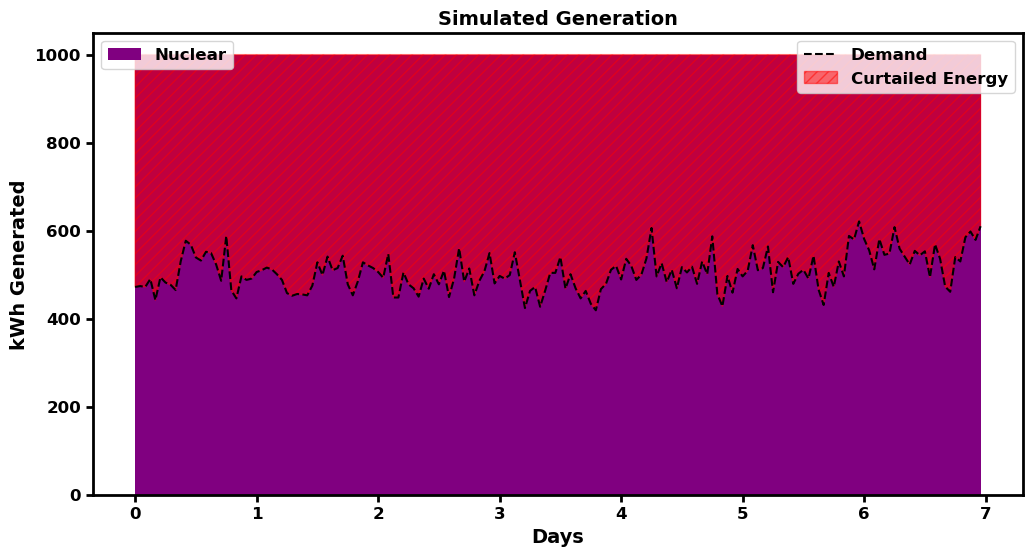

In [178]:
nuclear = [0, 0, 1, 0, 0, 0]
data = simulate_energy(nuclear)
start = '2019-05-01'
end = '2019-05-07'
data_subset = data[start:end].copy()
data_subset['Day'] = range(len(data_subset))  # Add a 'Day' column
data_subset['Day'] = data_subset['Day']/24

plt.figure(figsize=(12, 6))
colors = [ 'purple']  # Specify your own colors here
stack_plots = plt.stackplot(data_subset['Day'], data_subset['Nuclear'], colors =colors)

# Add a dotted line that traces demand for the two summer days
demand_line = plt.plot(data_subset['Day'], demand[start:end], 'k--', label = 'Demand')  # Assuming demand is defined somewhere in your code

# Calculate total energy for the two summer days
total_energy = data_subset['Nuclear']

# Shade the area between the stacked plot and the curtailed line
curtailed_fill = plt.fill_between(data_subset['Day'], total_energy, total_energy - data_subset['Curtailed'], color='red', alpha=0.5, hatch='///')
curtailed_patch = mpatches.Patch(color='red', alpha=0.5, hatch='///', label='Curtailed Energy')

plt.xlabel('Days')
plt.ylabel('kWh Generated')
plt.title('Simulated Generation')

# Create the first legend and add it to the plot
first_legend = plt.legend(stack_plots[::-1], ['Diesel', 'Nuclear'][::-1], loc='upper left')
plt.gca().add_artist(first_legend)

# Create the second legend and add it to the plot
plt.legend([demand_line[0], curtailed_patch], ['Demand', 'Curtailed Energy'], loc='upper right')    

plt.show()

## Cost

In [ ]:
solarwind1 = [20,2000, 0, 1000,0,1]
solarwind2 = [70,5400, 0, 1000,0,1]

In [ ]:
print(base)
print(solar1)
print(solar2)
print(solarBESS1)
print(solarBESS2)
print(wind1)
print(wind2)
print(windBESS1)
print(windBESS2)
print(solarwind1)
print(solarwind2)
print(hybrid1)
print(hybrid2)
print(renewableonly1)
print(renewableonly2)


[0, 0, 0, 0, 0, 1]
[0, 2000, 0, 0, 0, 1]
[0, 5400, 0, 0, 0, 1]
[0, 2000, 0, 1000, 10000, 1]
[0, 5400, 0, 1000, 12000, 1]
[20, 0, 0, 0, 0, 1]
[70, 0, 0, 0, 0, 1]
[20, 0, 0, 1000, 10000, 1]
[70, 0, 0, 1000, 12000, 1]
[20, 2000, 0, 1000, 10000, 1]
[70, 5400, 0, 1000, 12000, 1]
[20, 2000, 0, 1000, 10000, 1]
[70, 5400, 0, 1000, 12000, 1]
[20, 11800, 0, 1000, 20000, 1]
[70, 8600, 0, 1000, 15000, 1]


In [ ]:
print(calculate_cost(base))
print(calculate_cost(solar1))
print(calculate_cost(solar2))
print(calculate_cost(solarBESS1))
print(calculate_cost(solarBESS2))
print(calculate_cost(wind1))
print(calculate_cost(wind2))
print(calculate_cost(windBESS1))
print(calculate_cost(windBESS2))
print(calculate_cost(solarwind1))
print(calculate_cost(solarwind2))
print(calculate_cost(hybrid1))
print(calculate_cost(hybrid2))
print(calculate_cost(renewableonly1))
print(calculate_cost(renewableonly2))


(37389809.615999356, 37389809.615999356, 0)
(25100582.256000154, 23348582.256000154, 1752000)
(25618700.832000036, 20888300.832000036, 4730400)
(18121332.800000116, 11369332.800000114, 6752000)
(13789033.127999997, 3058633.127999997, 10730400)
(21334578.184000406, 18786578.184000406, 2548000)
(20233198.040000144, 11315198.040000144, 8918000)
(22013099.136000227, 14465099.136000227, 7548000)
(20825842.519999996, 5907842.519999994, 14918000)
(15304810.984000208, 11004810.984000208, 4300000)
(19285066.879999973, 5636666.879999974, 13648400)
(11531343.984, 2231343.9839999997, 9300000)
(19819338.512, 170938.512, 19648400)
(22884800.0, 0.0, 22884800)
(23951600.0, 0.0, 23951600)


In [ ]:
solarwind1 = [20,2000, 0, 1000,10000,1]
solarwind2 = [70,5400, 0, 1000,12000,1]
print(calculate_carbon(solarwind1))
print(calculate_carbon(solarwind2))
print(calculate_cost(solarwind1))
print(calculate_cost(solarwind2))

(7542.946526018139, 4446.743040728468, 3096.2034852896704, 22676.26, 3735394.1170882313)
(8350.549585217766, 340.6555170690705, 8009.894068148695, 1737.1799999999998, 21241014.88221242)
(11531343.984, 2231343.9839999997, 9300000)
(19819338.512, 170938.512, 19648400)


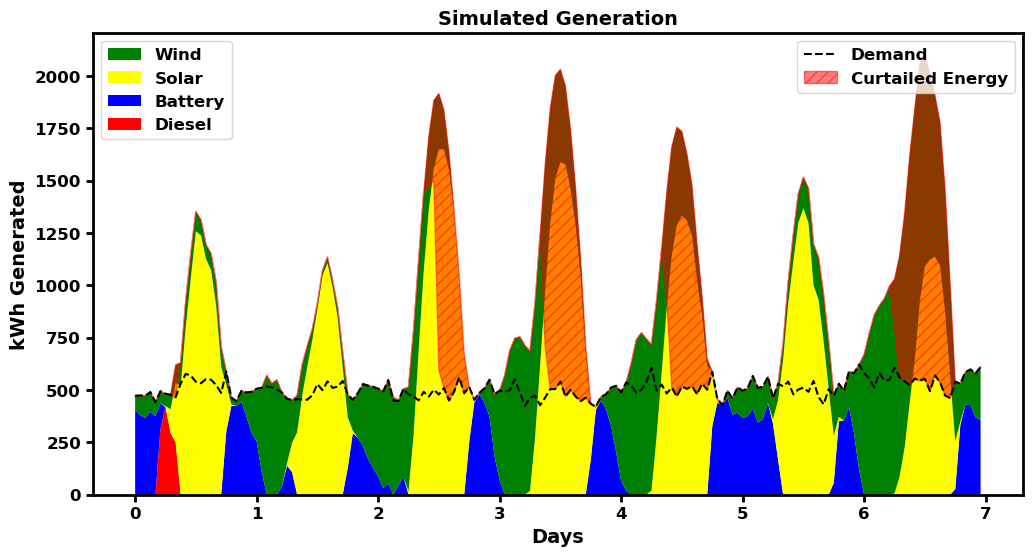

In [ ]:
plot_generation(simulate_energy(solarwind1), '2019-5-1', '2019-5-7')

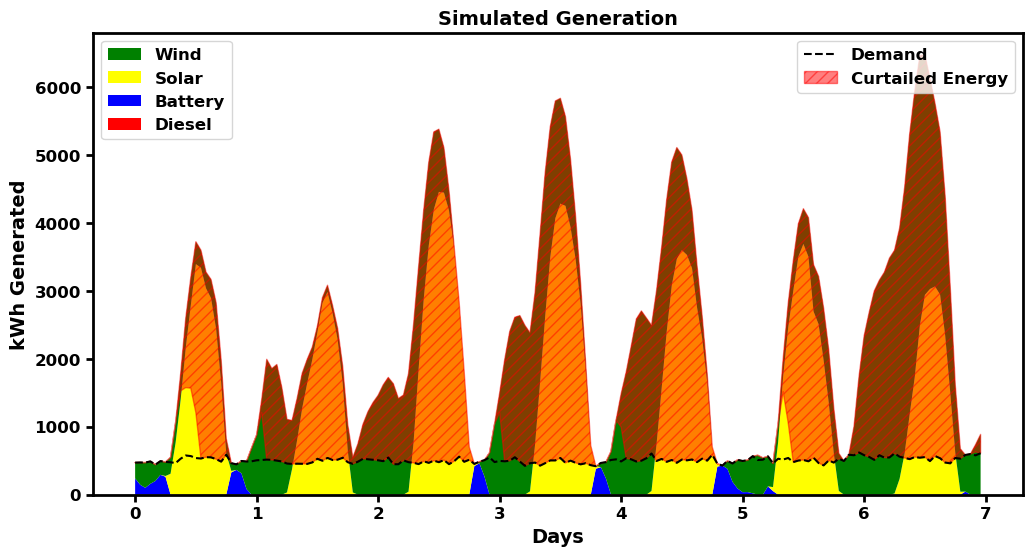

In [ ]:
plot_generation(simulate_energy(solarwind2), '2019-5-1', '2019-5-7')

## Carbon

In [ ]:
print(calculate_carbon(base))
print(calculate_carbon(solar1))
print(calculate_carbon(solar2))
print(calculate_carbon(solarBESS1))
print(calculate_carbon(solarBESS2))
print(calculate_carbon(wind1))
print(calculate_carbon(wind2))
print(calculate_carbon(windBESS1))
print(calculate_carbon(windBESS2))
print(calculate_carbon(hybrid1))
print(calculate_carbon(hybrid2))
print(calculate_carbon(renewableonly1))
print(calculate_carbon(renewableonly2))

(74512.43595622481, 74512.43595622481, 0.0, 379977.7399999935, 0.0)
(46901.340893686436, 46530.318230729994, 371.02266295644, 237282.34000000157, 1882130.0)
(42629.097460578145, 41627.33627059576, 1001.761189982388, 212279.48000000036, 7844303.799999989)
(24128.444319431266, 22657.421656474828, 1471.02266295644, 115542.00000000116, 89416.69999999998)
(8417.17080571268, 6095.409615730291, 2321.7611899823883, 31083.669999999973, 5188240.893333328)
(39064.09046505423, 37438.909642720995, 1625.1808223332305, 190920.51000000414, 2131717.419052108)
(28237.671855404995, 22549.538977238688, 5688.132878166307, 114991.85000000148, 12764250.127606453)
(31552.013160908424, 28826.83233857519, 2725.1808223332305, 147003.0400000023, 1579134.0418458772)
(18781.601155538694, 11773.468277372385, 7008.132878166307, 60039.04999999994, 12022703.931655819)
(7542.946526018139, 4446.743040728468, 3096.2034852896704, 22676.26, 3735394.1170882313)
(8350.549585217766, 340.6555170690705, 8009.894068148695, 1737.1

## hours satisfied 

In [ ]:

# #set the last value of each scenario to zero 
# solar1[-1] = 0
# solar2[-1] = 0
# solarBESS1[-1] = 0
# solarBESS2[-1] = 0
# wind1[-1] = 0
# wind2[-1] = 0
# windBESS1[-1] = 0
# windBESS2[-1] = 0
# solarwind1[-1] = 0
# solarwind2[-1] = 0
# hybrid1[-1] = 0
# hybrid2[-1] = 0
# renewableonly1[-1] = 0
# renewableonly2[-1] = 0
# #print the last value of met demand
# print(simulate_energy(solar1)['Metdemand'].iloc[-1])
# print(simulate_energy(solar2)['Metdemand'].iloc[-1])
# print(simulate_energy(solarBESS1)['Metdemand'].iloc[-1])
# print(simulate_energy(solarBESS2)['Metdemand'].iloc[-1])
# print(simulate_energy(wind1)['Metdemand'].iloc[-1])
# print(simulate_energy(wind2)['Metdemand'].iloc[-1])
# print(simulate_energy(windBESS1)['Metdemand'].iloc[-1])
# print(simulate_energy(windBESS2)['Metdemand'].iloc[-1])
# print(simulate_energy(solarwind1)['Metdemand'].iloc[-1])
# print(simulate_energy(solarwind2)['Metdemand'].iloc[-1])
# print(simulate_energy(hybrid1)['Metdemand'].iloc[-1])
# print(simulate_energy(hybrid2)['Metdemand'].iloc[-1])
# print(simulate_energy(renewableonly1)['Metdemand'].iloc[-1])
# print(simulate_energy(renewableonly2)['Metdemand'].iloc[-1])



2938
3696
5805
7934
3466
5731
4820
7238
8118
8710
8118
8710
8760
8760
